In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
tf.__version__

'1.9.0'

In [222]:
# load dataset

from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

# insights of dataset
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


# Placeholders

In [4]:
# placeholder for input images
"""
Why reshape to -1? -1 is a placeholder that says 
"adjust as necessary to match the size needed for the full tensor." 
It's a way of making the code be independent of the input batch size, 
so that you can change your pipeline and not have to adjust the batch size 
everywhere in the code.
"""
x = tf.placeholder(tf.float32, [None,28*28], name='X')
x_image = tf.reshape(x,[-1,28,28,1])

# placeholder for true y labels associated with images
y_true = tf.placeholder(tf.float32, [None, 10], name='Y')
y_true_cls = tf.argmax(y_true, axis=1)

## convolutional layer 1

In [5]:
# weights shape = [height_of_filter, width_of_filter, no_ip_channels, depth_of_layer]
# here depth_of_layer is no. of feature maps
# using 5X5 filter

In [6]:
w_conv1 = tf.Variable(tf.truncated_normal(shape=[5,5,1,6]))
b_conv1 = tf.Variable(tf.constant(0.01, shape=[6]))

conv1 = tf.nn.conv2d(x_image, w_conv1, strides=[1,1,1,1], padding='SAME')+ b_conv1
# note that output of conv1 is 6 28X28 images
conv1

<tf.Tensor 'add:0' shape=(?, 28, 28, 6) dtype=float32>

## relu layer 1

In [7]:
relu1 = tf.nn.relu(conv1)
relu1

<tf.Tensor 'Relu:0' shape=(?, 28, 28, 6) dtype=float32>

## pooling layer 1

In [8]:
# kernel size [no_of_kernels, kernel_height, kernel_width, no_of_channels]
pool1 = tf.nn.max_pool(value=relu1, ksize=[1,2,2,1], strides=[1,1,1,1], padding='SAME')
pool1

<tf.Tensor 'MaxPool:0' shape=(?, 28, 28, 6) dtype=float32>

## convolutional layer 2

In [9]:
# <tf.Tensor 'Relu_2:0' shape=(?, 28, 28, 6) dtype=float32>
# we have 6 feature maps of 28 by 28
# notice : w_conv2 = tf.Variable(tf.truncated_normal(shape=[2,2,6,32]))
# now we convolute using 2 by 2 filter and get 32 feature maps

w_conv2 = tf.Variable(tf.truncated_normal(shape=[2,2,6,32]))
b_conv2 = tf.Variable(tf.constant(0.05, shape=[32]))

conv2 = tf.nn.conv2d(pool1, w_conv2, strides=[1,1,1,1], padding='SAME')+ b_conv2
# note that output of conv1 is 6 28X28 images
conv2

<tf.Tensor 'add_1:0' shape=(?, 28, 28, 32) dtype=float32>

## relu layer 2

In [10]:
relu2 = tf.nn.relu(conv2)
relu2

<tf.Tensor 'Relu_1:0' shape=(?, 28, 28, 32) dtype=float32>

## pooling layer 2

In [11]:
# kernel size [no_of_kernels, kernel_height, kernel_width, no_of_channels]
# notice strides=[1,2,2,1]
# after sliding 2 cells at a time dimensionality reduction can be seen
# pool2 <tf.Tensor 'MaxPool_2:0' shape=(?, 14, 14, 32) dtype=float32>
pool2 = tf.nn.max_pool(value=relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
pool2

<tf.Tensor 'MaxPool_1:0' shape=(?, 14, 14, 32) dtype=float32>

## fully connected network 1

In [12]:
# fcn1 fully connected network
# now we flatten all the feature maps and
# send it to fully connected network

fcn_mat1 = tf.reshape(pool2,shape=[-1,14*14*32])
fcn_mat1

<tf.Tensor 'Reshape_1:0' shape=(?, 6272) dtype=float32>

In [13]:
# weights and biases for fcn1
w_fcn1 = tf.Variable(tf.truncated_normal(shape=[14*14*32,256],stddev=0.5))
b_fcn1 = tf.Variable(tf.constant(value=0.3 , shape=[256]))

# mat mul operation
mat_mul_fcn1 = tf.matmul(fcn_mat1,w_fcn1) + b_fcn1
mat_mul_fcn1

<tf.Tensor 'add_2:0' shape=(?, 256) dtype=float32>

## relu layer 3

In [14]:
relu3 = tf.nn.relu(mat_mul_fcn1)
relu3

<tf.Tensor 'Relu_2:0' shape=(?, 256) dtype=float32>

## fully connected network 2

In [15]:
# weights and biases for fcn1
w_fcn2 = tf.Variable(tf.truncated_normal(shape=[256,10],stddev=0.5))
b_fcn2 = tf.Variable(tf.constant(value=0.05 , shape=[10]))

# mat mul operation
mat_mul_fcn2 = tf.matmul(relu3,w_fcn2) + b_fcn2
mat_mul_fcn2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

## applying softmax

In [16]:
# softmax will generate probabilities 
# or scores of each digit we need to choose max probability
# axis = 1 meaning in columns

y_pred = tf.nn.softmax(mat_mul_fcn2)
y_pred_cls = tf.argmax(y_pred,axis=1)

# cost function

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=mat_mul_fcn2, labels=y_true)
cost =tf.reduce_mean(cross_entropy)

# optimiser and accuracy

In [18]:
# using adam optimiser
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# Accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# this is to convert integer to float32 for accuracy check
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## setting parameters

In [22]:
num_epochs = 5
batch_size = 100

# Session

In [20]:
sess = tf.InteractiveSession()

In [27]:
train_acc_array = []
valid_acc_array = []
test_acc_array = []
pred_results = []

# initialize all global variables
sess.run(tf.initializers.global_variables())
total_time_t0 = time.time()

for epochs in range(num_epochs):

    start_time = time.time()
    train_accuracy = 0

    # Training-set consists: 55000
    # Using only 50 epochs
    # Training only 10 batches per epoch
    # Therefore total of 50*10 iterations
    for batch in range(100):

        # get batch of images and labels
        x_batch, y_true_batch = data.train.next_batch(batch_size)

        # set feed_dict_train
        feed_dict_train = {x:x_batch, y_true:y_true_batch}

        # feed dictionary into optimiser for training
        sess.run(optimizer,feed_dict=feed_dict_train)

        # Calculate the cumulative accuracy on the batch of training data
        train_accuracy += sess.run(accuracy, feed_dict=feed_dict_train)
        # print("*** Train_accuracy_batch",train_accuracy)


    # get validation sets
    v_img, v_labels = data.validation.next_batch(100)
    # feed validation set
    vali_accuracy = sess.run(accuracy, feed_dict={x:data.validation.images, y_true:data.validation.labels})

    # get test sets
    tst_imgs, tst_labels = data.test.next_batch(100)
    # check over test set
    test_accuracy = sess.run(accuracy, feed_dict={x:tst_imgs, y_true:tst_labels})
    
    # printing test images and their labels
    pred_batch_x, pred_batch_y = data.test.next_batch(5)
    pred_results.append([pred_batch_x,sess.run(y_pred,feed_dict={x:pred_batch_x})])

    # average train accuracy
    # train_accuracy /= int(len(data.train.labels)/batch_size)
    train_accuracy /= 100
    
    # appending in arrays for plotting
    train_acc_array.append(train_accuracy)
    valid_acc_array.append(vali_accuracy)
    test_acc_array.append(test_accuracy)
    

    end_time = time.time()
    print("Epoch "+str(epochs+1)+" completed : Time usage "+str(int(end_time-start_time))+" seconds")
    print("\tAccuracy:")
    print ("\t- Training Accuracy:\t{}".format(train_accuracy))
    print ("\t- Validation Accuracy:\t{}".format(vali_accuracy))
    print ("\t- Test Accuracy:\t{}".format(test_accuracy))

total_time_tn = time.time()
print("Total time required to train: ",total_time_tn-total_time_t0)

Epoch 1 completed : Time usage 41 seconds
	Accuracy:
	- Training Accuracy:	0.17260000055655836
	- Validation Accuracy:	0.3336000144481659
	- Test Accuracy:	0.30000001192092896
Epoch 2 completed : Time usage 39 seconds
	Accuracy:
	- Training Accuracy:	0.4781999981403351
	- Validation Accuracy:	0.5820000171661377
	- Test Accuracy:	0.5799999833106995
Epoch 3 completed : Time usage 41 seconds
	Accuracy:
	- Training Accuracy:	0.6474000012874603
	- Validation Accuracy:	0.6904000043869019
	- Test Accuracy:	0.6299999952316284
Epoch 4 completed : Time usage 39 seconds
	Accuracy:
	- Training Accuracy:	0.7330000007152557
	- Validation Accuracy:	0.7576000094413757
	- Test Accuracy:	0.6899999976158142
Epoch 5 completed : Time usage 40 seconds
	Accuracy:
	- Training Accuracy:	0.7862999957799911
	- Validation Accuracy:	0.7964000105857849
	- Test Accuracy:	0.8299999833106995
Total time required to train:  202.3239517211914


# Visualising

In [220]:
pred_results[4]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]

0
5
0
8


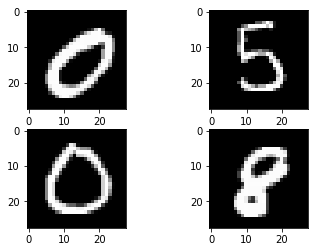

In [221]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(np.reshape(pred_results[4][0][0],(28,28)),cmap='gray');print(np.argmax(pred_results[4][1][0]))
axarr[0,1].imshow(np.reshape(pred_results[4][0][1],(28,28)),cmap='gray');print(np.argmax(pred_results[4][1][1]))
axarr[1,0].imshow(np.reshape(pred_results[4][0][2],(28,28)),cmap='gray');print(np.argmax(pred_results[4][1][2]))
axarr[1,1].imshow(np.reshape(pred_results[4][0][3],(28,28)),cmap='gray');print(np.argmax(pred_results[4][1][3]))
plt.show()